## SVM(Soft Vector Machine)SVR SVM 서포트 벡터 머신의 변형 모델. 
#### 비트코인 종가 예측 모델 : 과소적합.  
#### 트레이닝,테스트 데이터셋에서 평가지표 음수로 나옴, 최종 비트코인 예측가격이 아쉬움.


### 1. 라이브러리

In [15]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but StandardScaler was fitted with feature names")      

### 2. 데이터 연결

In [16]:
stock_df          = pd.read_excel('tb_stock.xlsx')
main_economic     = pd.read_excel('tb_main_economic_index.xlsx')
us_economic       = pd.read_excel('tb_us_economic_indicator.xlsx')

stock_df          = stock_df[['sc_date', 'sc_coin']]
main_economic     = main_economic[['mei_date', 'mei_dow']]
us_economic       = us_economic[['uei_date', 'uei_cpi', 'uei_trade','uei_ps_m','uei_rs_m']]

stock_df.rename(columns={'sc_date' :'date'}, inplace=True)
main_economic.rename(columns={'mei_date' :'date'}, inplace=True)
us_economic.rename(columns={'uei_date' :'date'}, inplace=True)

# 데이터프레임 병합
merged_df         = pd.merge(stock_df, main_economic, on='date', how='inner')
merged_df         = pd.merge(merged_df, us_economic, on='date', how='inner')

data = merged_df

# 전처리 시계열 데이터를 기반으로 이동 평균, 차분 추가
data['MA_7']     = data['sc_coin'].rolling(window=7).mean()                                          # 7일 이동 평균 (추세 과거 7일 평균주가 변동성 완화 관찰)
data['Diff']     = data['sc_coin'].diff()                                                            # 변화의 하루 차분 파악

data = data.dropna()   

### 3. 데이터 분할 및 정규화

In [17]:
# 2. 데이터 분할 및 정규화
X       = data.drop(['sc_coin', 'date'], axis=1)                                                     # 피처와 타겟 변수 분리 (날짜 컬럼 제외)
y       = data['sc_coin']

# 전체 데이터 포인트 수 확인
print(f"전체 데이터 수: {X.shape[0]}")

# train_test_split 후 데이터셋의 크기 확인
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"학습 데이터 수: {X_train.shape[0]}")
print(f"테스트 데이터 수: {X_test.shape[0]}")

print(f'X_train shqpe : {X_train.shape}, y_train shape : {y_train.shape}')
print(f'X_test shqpe : {X_train.shape}, y_test shape : {y_train.shape}')

# 특성 스케일링 (정규화)
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

전체 데이터 수: 3614
학습 데이터 수: 2891
테스트 데이터 수: 723
X_train shqpe : (2891, 7), y_train shape : (2891,)
X_test shqpe : (2891, 7), y_test shape : (2891,)


### 4. 그리드서치

In [18]:
svr          = SVR()                                                                                       # 모델 정의 

param_grid   = {
    'C'      : [0.01, 0.1, 1, 10, 40],                                                                     # 모델의 복잡도와 과적합 제어 40 적당한 범위로 규제
    'gamma'  : ['scale',                                                                                   # 'scale': 입력 데이터의 특성 수에 따라 자동으로 gamma 값을 설정
                'auto',                                                                                    # 'auto' : 1/5(특성수) = 0.2
                0.0001, 0.001, 0.01, 0.1, 1],                                                              # 포인트 영향 범위 : 0.01 큰 범위로 제한, 결정 경계가 더 복잡할 수 있음.
    'epsilon': [0.0001, 0.001, 0.01, 0.1, 0.5],                                                            # 오차 허용 범위 0.5 (높을수록 간단한 모델) 예측과 실제 값 사이에서 무시할 수 있는 오류의 범위를
    'kernel' : ['rbf'],                                                                                    # 비선형 rbf 커널 고정 그렇지 않으면 종가 가격이 음수로 나옴. 
}

grid_search  = GridSearchCV(svr, param_grid, cv=5, scoring='r2')                                           # 교차검증 svr모델 정의 파라미터 그리드(param_grid)를 사용 5폴드,평가 지표는 결정 계수(R^2)를 사용하여 모델의 설명력을 측정
grid_search.fit(X_train, y_train)

best_svr     = grid_search.best_estimator_
print(f"최적의 파라미터: {grid_search.best_params_}")

최적의 파라미터: {'C': 40, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


### 5. 평가지표

In [21]:
y_pred      = best_svr.predict(X_test)                                                                                  

mse         = mean_squared_error(y_test, y_pred)                                                           # 평균 제곱 오차 (실제값과 예측값의 차이) 값이 작을수록 실제값과 가까움
r2          = r2_score(y_test, y_pred)                                                                     # 결정 계수
mae         = mean_absolute_error(y_test, y_pred)                                                          # 평균 절대 오차 (예측값과 실제값 사이의 차이의 절대값 평균) 제곱하지 않기에, 이상치에 덜 민감.
rmse        = mean_squared_error(y_test, y_pred, squared=False)                                            # 루트 평균 제곱 오차(mse^2)예측값과 실제 값 사이의 오차를 실제 단위로 표현. 값이 작을수록 예측이 더 정확함.                  

print(f"테스트 데이터 평가:")
print(f"오차 제곱 평균(mse): {mse}")
print(f"데이터 변동성(R^2): {r2}")
print(f"절대적 오차 (MAE): {mae}")
print(f"평균의 제곱근을 취한 값 (RMSE): {rmse}")

y_train_pred = best_svr.predict(X_train)
train_mse    = mean_squared_error(y_train, y_train_pred)
train_r2     = r2_score(y_train, y_train_pred)

print(f"\n학습 데이터 평가:")
print(f"학습 데이터셋에 대한 모델의 성능을 평가 (MSE): {train_mse}")
print(f"학습 데이터셋에 대한 모델의 성능을 평가 R^2 점수: {train_r2}")

print("\n모델 평가:")
if train_r2 >= 0.8 and r2 < 0.8:
    print("과적합 가능성: 모델이 학습 데이터에 비해 테스트 데이터에서 성능이 낮음. 모델이 학습 데이터에 너무 적합되었을 수 있음.")
elif train_r2 < 0.8 and r2 < 0.8:
    print("과소적합 가능성: 모델이 학습 데이터와 테스트 데이터 모두에서 성능이 낮음. 모델이 데이터를 충분히 학습하지 못했을 수 있음.")
elif train_r2 >= 0.8 and r2 >= 0.8:
    print("모델이 잘 일반화되었습니다: 학습 데이터와 테스트 데이터 모두에서 높은 성능을 보임.")
else:
    print("예외적인 상황: 학습 데이터의 성능이 낮으나, 테스트 데이터의 성능이 높은 경우입니다. 일반적으로는 드문 상황입니다.")

C:\Users\mys11\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


테스트 데이터 평가:
오차 제곱 평균(mse): 515276649.0082172
데이터 변동성(R^2): -0.6791853664398073
절대적 오차 (MAE): 16210.095824948925
평균의 제곱근을 취한 값 (RMSE): 22699.70592338626

학습 데이터 평가:
학습 데이터셋에 대한 모델의 성능을 평가 (MSE): 143753023.14452592
학습 데이터셋에 대한 모델의 성능을 평가 R^2 점수: 0.4720315099640887

모델 평가:
과소적합 가능성: 모델이 학습 데이터와 테스트 데이터 모두에서 성능이 낮음. 모델이 데이터를 충분히 학습하지 못했을 수 있음.


### 6. 시각화

C:\Users\mys11\AppData\Local\Temp\ipykernel_23804\414799538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], errors='coerce')


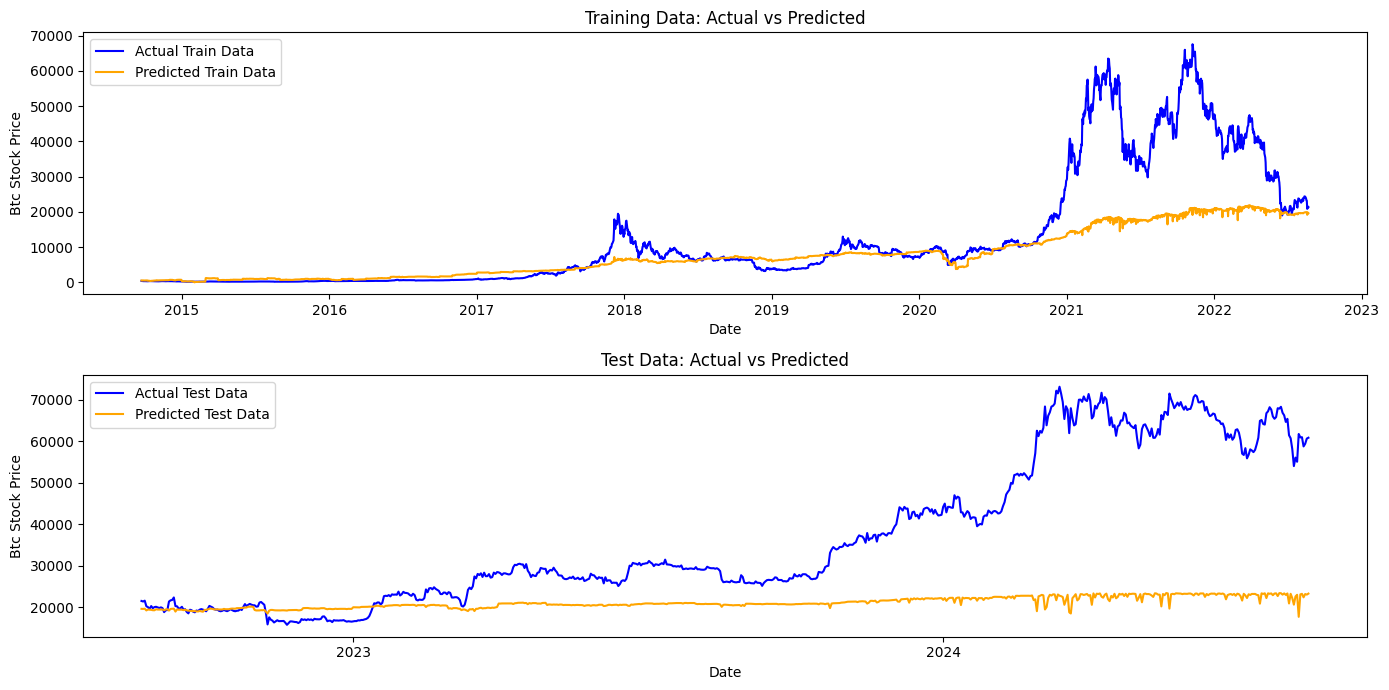

In [22]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data         = data.dropna(subset=['date'])

y_train_pred = best_svr.predict(X_train)
y_test_pred  = best_svr.predict(X_test)

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)  
plt.plot(data['date'].iloc[:len(y_train)], y_train.values, label='Actual Train Data', color='blue')
plt.plot(data['date'].iloc[:len(y_train)], y_train_pred, label='Predicted Train Data', color='orange')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Btc Stock Price')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.subplot(2, 1, 2)  
plt.plot(data['date'].iloc[len(y_train):], y_test.values, label='Actual Test Data', color='blue')
plt.plot(data['date'].iloc[len(y_train):], y_test_pred, label='Predicted Test Data', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Btc Stock Price')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

### 7. 시각화 (편차 추가)

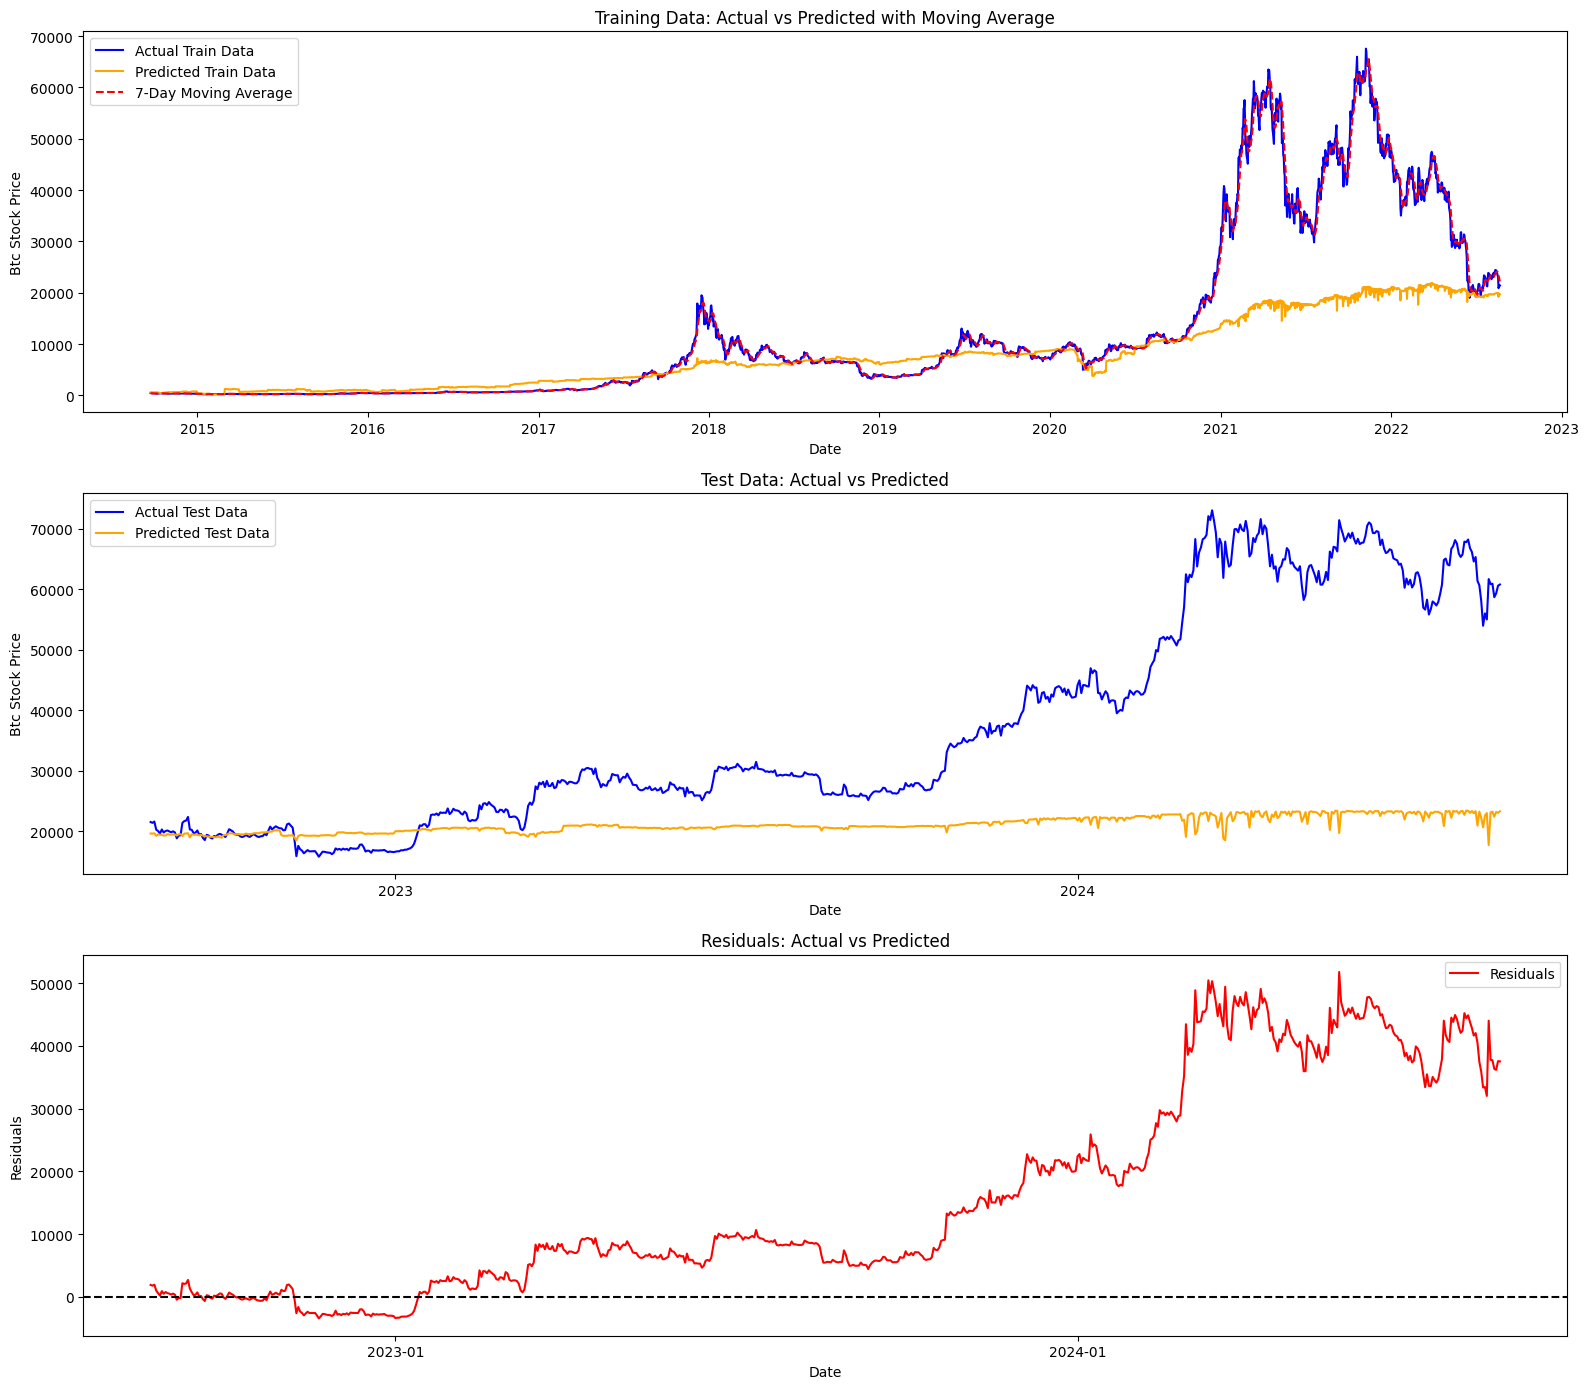

In [25]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')

data = data.dropna(subset=['date'])

y_train_pred = best_svr.predict(X_train)
y_test_pred  = best_svr.predict(X_test)

plt.figure(figsize=(16, 14))

plt.subplot(3, 1, 1)                                                                                       # 3행 1열의 첫 번째 서브플롯 생성
plt.plot(data['date'].iloc[:len(y_train)], y_train.values, label='Actual Train Data', color='blue')        # 실제 학습 데이터 시각화 (파란색 선)
plt.plot(data['date'].iloc[:len(y_train)], y_train_pred, label='Predicted Train Data', color='orange')     # 예측된 학습 데이터 시각화 (주황색 선)
plt.plot(data['date'].iloc[:len(y_train)], data['MA_7'].iloc[:len(y_train)], 
        label='7-Day Moving Average', color='red', linestyle='--')                                         # 7일 이동 평균 시각화 (빨간색 점선)
plt.title('Training Data: Actual vs Predicted with Moving Average')                                        # 그래프 제목 설정
plt.xlabel('Date')                                                                                         # x축 레이블 설정
plt.ylabel('Btc Stock Price')                                                                              # y축 레이블 설정
plt.legend()                                                                                               # 범례 표시


plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.subplot(3, 1, 2) 
plt.plot(data['date'].iloc[len(y_train):], y_test.values, label='Actual Test Data', color='blue')
plt.plot(data['date'].iloc[len(y_train):], y_test_pred, label='Predicted Test Data', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Btc Stock Price')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

residuals = y_test - y_test_pred
plt.subplot(3, 1, 3)  
plt.plot(data['date'].iloc[len(y_train):], residuals, label='Residuals', color='red')
plt.axhline(0, color='black', linestyle='--')                                                                                     
plt.title('Residuals: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

### 8. 임의의 값 테스트 (4주 후)

In [24]:
from datetime import timedelta                                                                  # timedelta 모듈을 사용해 날짜와 시간을 더하거나 뺄 때 사용
import numpy as np                                                                              # 숫자 계산을 위한 numpy 라이브러리
import pandas as pd                                                                             # 데이터 처리와 분석을 위한 pandas 라이브러리
import matplotlib.pyplot as plt                                                                 # 데이터 시각화를 위한 matplotlib 라이브러리
import matplotlib.dates as mdates                                                               # 날짜 포맷팅을 위한 matplotlib의 dates 모듈

# 4주 예측 학습
last_train_date = data['date'].iloc[len(y_train) - 1]                                           # 훈련 데이터의 마지막 날짜를 추출
                                                                                                # data['date']: 전체 데이터셋에서 'date' 열을 선택
                                                                                                # len(y_train) - 1: 훈련 데이터의 길이를 이용해 마지막 인덱스를 계산
                                                                                                # iloc: 데이터프레임에서 위치 기반 인덱싱을 사용하여 날짜를 추출

# 4주 후 예측 날짜 계산
prediction_date = last_train_date + timedelta(weeks=4)                                          # 마지막 훈련 날짜에 4주를 더해 예측 날짜를 계산
                                                                                                # timedelta(weeks=4): 4주를 나타내는 timedelta 객체를 생성

# 마지막 데이터 포인트 추출 및 데이터프레임 생성
last_test_data = X_test[-1:]                                                                    # 테스트 데이터에서 마지막 데이터 포인트를 추출
last_test_df = pd.DataFrame(last_test_data, columns=X.columns)                                  # 마지막 데이터 포인트를 사용해 데이터프레임 생성
                                                                                                # columns=X.columns: 원본 데이터의 열 이름을 유지

# 스케일링 적용
input_scaled = scaler.transform(last_test_df)                                                   # 스케일링된 데이터로 변환
                                                                                                # scaler.transform: 학습된 스케일러를 사용해 마지막 테스트 데이터를 변환

# 예측 수행 (학습된 best_svr 모델 사용)
predicted_value = best_svr.predict(input_scaled)                                                # 최적의 SVR 모델(best_svr)을 사용해 예측 값 생성

# 예측된 값 확인
print(f"예측된 값 (원본): {predicted_value}")                                                    # 예측된 값을 출력해 확인

# 예측된 값이 음수일 경우 0으로 변경
predicted_value = np.maximum(predicted_value, 0)                                                # 예측된 값이 음수일 경우 0으로 변경하여 논리적 결과 보장
                                                                                                # np.maximum: 각 원소별로 0과 비교해 큰 값을 반환

# 예측된 값의 형태를 확인하고 필요할 경우 형식을 변경
if predicted_value.ndim == 1:                                                                   # 예측된 값이 1차원 배열일 경우 2차원으로 변환
    predicted_value = predicted_value.reshape(-1, 1)                                            # reshape(-1, 1): 1차원 배열을 2차원 열 벡터로 변환

# 예측된 값의 스케일 복원 (필요한 경우, 예: StandardScaler를 적용한 경우)
# y_scaler가 적용되었다면:
# predicted_value = y_scaler.inverse_transform(predicted_value)                                 # 예측 값의 스케일을 원래대로 복원 (필요한 경우에만)

# 결과 출력
print(f"마지막 학습 날짜: {last_train_date}")                                                    # 마지막 학습 날짜를 출력
print(f"예측 날짜 (4주 후): {prediction_date}")                                                  # 예측한 날짜(4주 후)를 출력
print(f"예측된 삼성전자 종가: {predicted_value[0][0]:.2f}")                                       # 예측된 삼성전자 종가를 소수점 둘째 자리까지 출력


# 결과 출력
print(f"마지막 학습 날짜: {last_train_date}")
print(f"예측 날짜 (4주 후): {prediction_date}")
print(f"예측된 삼성전자 종가: {predicted_value[0][0]:.2f}")

예측된 값 (원본): [10126.51304118]
마지막 학습 날짜: 2022-08-22 00:00:00
예측 날짜 (4주 후): 2022-09-19 00:00:00
예측된 삼성전자 종가: 10126.51
마지막 학습 날짜: 2022-08-22 00:00:00
예측 날짜 (4주 후): 2022-09-19 00:00:00
예측된 삼성전자 종가: 10126.51


### 9. 결과 시각화

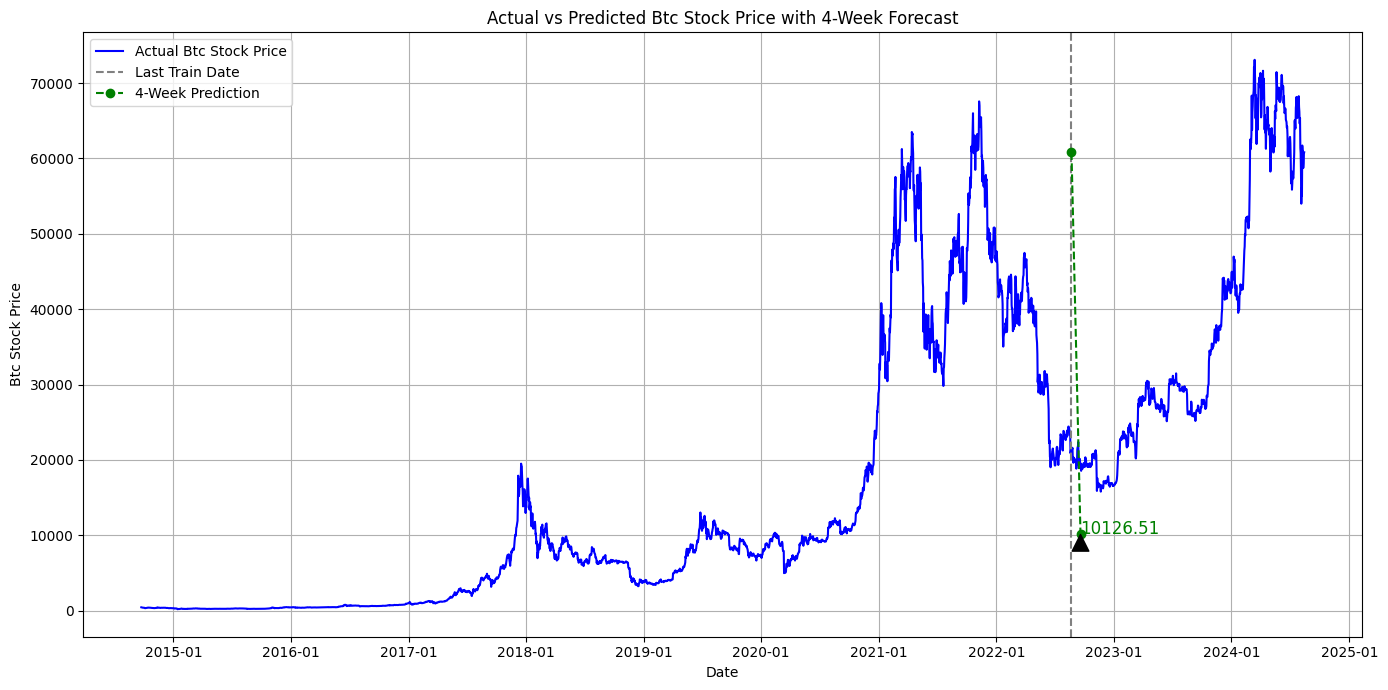

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 실제 데이터 및 예측 값 시각화
plt.figure(figsize=(14, 7))

# 실제 데이터 플로팅
plt.plot(data['date'], data['sc_coin'], label='Actual Btc Stock Price', color='blue')            # 실제 비트코인 종가를 플로팅 (파란색 선)

# 훈련 데이터의 마지막 날짜 표시
plt.axvline(x=last_train_date, color='grey', linestyle='--', label='Last Train Date')            # 마지막 학습 날짜 표시 (회색 점선)

# 4주 후 예측 결과를 선으로 표시
plt.plot([last_train_date, prediction_date], [data['sc_coin'].iloc[-1], predicted_value[0][0]], 
        label='4-Week Prediction', color='green', linestyle='--', marker='o')                    # 4주 후 예측 결과를 선으로 연결 (녹색 점선, 원형 마커)

# 예측 값에 주석 추가
plt.annotate(f'{predicted_value[0][0]:.2f}', xy=(prediction_date, predicted_value[0][0]), 
            xytext=(prediction_date, predicted_value[0][0] + 0.1),                               # 주석 텍스트 위치 조정
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='green')         # 주석의 화살표 스타일 설정

# 그래프 제목 및 레이블 설정
plt.title('Actual vs Predicted Btc Stock Price with 4-Week Forecast')                             # 그래프 제목 설정
plt.xlabel('Date')                                                                                # x축 레이블 설정
plt.ylabel('Btc Stock Price')                                                                     # y축 레이블 설정


# 범례 표시
plt.legend()

# x축의 날짜 형식 설정
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 그리드 표시
plt.grid()

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()


### 11. 모델 저장

In [28]:
model_filename = 'regression_bitcoin_svm.joblib'
joblib.dump(scaler, 'regression_samsung_svm_scaler.joblib')
joblib.dump(best_svr, model_filename)

print(f"모델이 '{model_filename}'로 저장되었습니다.")

모델이 'regression_bitcoin_svm.joblib'로 저장되었습니다.
